<a href="https://colab.research.google.com/github/samuelhurni/ML-Cellsegmentation-HSLU-FS24/blob/feature_Sam/Sartorius_segmentation_kaggle_Sam_v005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Sartorius - Cell Instance Segmentation
##Detect single neuronal cells in microscopy images

Project HSLU Master IT Digitalization & Sustainability
Module: Machine Learning and Data Science
* Samuel Hurni
* Pradanendr Sudev  
* Chakravarti Devanandini




### 0.1 General information and references

Used Third party Libraries:
* Pytorch
* TQDM
* Pandas
* Numpy
* gdown
* Matplotlib

Used Thid party Imports:
* Auxiliary functions metric: "https://www.kaggle.com/code/theoviel/competition-metric-map-iou
* Auxiliary functions for encoding and decoding the mask: "https://www.kaggle.com/code/enzou3/sartorius-mask-r-cnn"



References to Turtorials / Code documantation:
* Pytorch documentation: https://pytorch.org/docs/stable/index.html
* Pytorch Turtorial: https://www.learnpytorch.io/00_pytorch_fundamentals/
* Kaggel dataset for ideas: https://www.kaggle.com/code/enzou3/sartorius-mask-r-cnn
  * build own method based on `find_best_thresholds()`



  **Important:**
  **Please check the Hyperparameters for this File because this allows you for example to run the project with limited images or load pretrained models**

### 0.2 About the project

Link to the project as follow: https://www.kaggle.com/competitions/sartorius-cell-instance-segmentation




Main objectives:

This Kaggle competition is about creating a computer program to identify and outline individual nerve cells in microscope images. These nerve cells are important for studying brain diseases like Alzheimer's and brain tumors, which are major health problems worldwide. Typically, scientists look at these cells using a microscope, but finding each cell in the images can be tough and takes a lot of time. Doing this accurately could help find new treatments for these diseases.

The challenge is that current methods aren't very good at recognizing these nerve cells, especially a kind called neuroblastoma cells, which look very different from other cells and are hard to identify with existing tools.

Sartorius, a company that supports science and medicine research, is sponsoring this competition. They want participants to develop a method that can automatically and precisely identify different types of nerve cells in images. This would be a big step forward in neurological research, making it easier for scientists to understand how diseases affect nerve cells and possibly leading to the discovery of new medications.



Dataset:

The Dataset containa at arround xx images for training and xx images for testing. the goal would be to train a model whoch is able to segment neuronal cells.


The ground truth data to the images for training consist several meta data which includes also the masks for training the segmentation problem. These are specified field of ecah datapoint:


* _id - unique identifier for object_

* _annotation - run length encoded pixels for the identified neuronal cell_

* _width - source image width_

* _height - source image height_

* _cell_type - the cell line_

* _plate_time - time plate was created_

* _sample_date - date sample was created_

* _sample_id - sample identifier_

* _elapsed_timedelta - time since first image taken of sample_



## 1.Preparations: Loading Dataset and install or import Packages

### 1.1 Install adn import third party packages / functions

In this chapter we install the third party packages which maybe are not installed in the prebuild google collab or on your local system

* Tqdm --> progress bar
* gdown --> Import google drive package


In [ ]:
# Install gdown:
try:
    import gdown
except ImportError:
    !pip install gdown

# Install tqdm:
try:
    import tqdm
except ImportError:
    !pip install tqdm

In [ ]:
# General Import which are used in this file
import pandas as pd
import numpy as np
import string
import os.path
import os
from tqdm.auto import tqdm
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from sklearn.preprocessing import MultiLabelBinarizer
import requests
import requests
import zipfile
from pathlib import Path
import gdown
from sklearn.metrics import fbeta_score

###1.2 Hyperparameters

In [ ]:
BASE_PATH = "dataset/sartorius-cell-instance-segmentation"
TRAIN_PATH = BASE_PATH + "/train"
TEST_PATH = BASE_PATH + "/test"
TRAIN_CSV = BASE_PATH + "/train.csv"

IMG_WIDTH = 704
IMG_HEIGHT = 520

TEST = False

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# # Will be used to normalize pictures
# RESNET_MEAN = (0.485, 0.456, 0.406)
# RESNET_STD = (0.229, 0.224, 0.225)

BATCH_SIZE = 1

MOMENTUM = 0.9
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005

# Confidence required for a pixel to be kept for a mask
MASK_THRESHOLD = 0.5

# Dictionaries to classify each type of cell
CELL_TYPE_DICT = {"astro": 1, "cort": 2, "shsy5y": 3}
DICT_TO_CELL = {1: "astro", 2: "cort", 3: "shsy5y"}
MASK_THRESHOLD_DICT = {1: 0.55, 2: 0.75, 3:  0.6}
MIN_SCORE_DICT = {1: 0.55, 2: 0.75, 3: 0.5}

# Normalize to resnet mean and std if True.
NORMALIZE = False


# Using a learning rate scheduler
USE_SCHEDULER = True

# Number of epochs in training
NUM_EPOCHS = 8

BOX_DETECTIONS_PER_IMG = 539

### 1.2 Define custom functions for this Project:

In this chapter we are defining custom functions which we are using throughout this project:

* `show_train_time` function to show the time how long the coputation of the model takes
* `folder_content` function to display what is inside a folder
* `check_drop_image_existence` function to drop from the label dataset images which are not in the file system
* `accuracy_fn` function for multi-label calssification problems
* `plot_loss_values` for plotting the loss and accuracy to detect under or overfitting
* `model_rating` gives back the rating of the model with accuracy and score for a given dataloader dataset
* `make_pred` make predictions with a model based on test data
* `combine_models_predictions_2` combines the results of two models with the size of 4 and 13 labels to a result of 17 labels
* `make_pred_combined` make predctions for the combined approach  with two models, one for the weather labels and another for the other labelsm



In [ ]:
# Define the timing function:
from timeit import default_timer as timer
def show_train_time(start:float,
                     end:float,
                     device: torch.device = None):
  """Show differnences between start and end time for calculation the performance of a pytorch model"""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [ ]:
def folder_content(directory_path):
  """
  Iterating thorugh all folders in the path and display the content.
  Args:
    directory_path --> Path to start iteration

  Returns:
    Show information about:
      subdiretories in dir_path
      number of files in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(directory_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
def check_drop_image_existence(label_data: pd.DataFrame, images_dir : string):
  """
  Method which cleans the label dataframe by checking the existence of images
  """
  data_frame = label_data
  index_drop = []
  #print(f"Check Images in Folder {images_dir}")
  for index, row in tqdm(data_frame.iterrows(), desc="Checking if File Exists....."):
    path_to_check = os.path.join(images_dir, row['image_name'])
    file_exists = os.path.isfile(path_to_check)
    if file_exists == False:
      # File does not exist, drop row from dataset
      #print(f"File: {row['image_name']} in Label file does not exist as image and will be deleted from the label file")
      index_drop.append(index)

  #Drop all rows in index_drop
  for index in tqdm(index_drop, desc="Deleting rows in label dataset....."):
    data_frame.drop(index, inplace=True)
  return data_frame

In [ ]:
# transformation functions

# Adjustments to PyTorch transformation classes to accommodate masks and targets
# Inspired by Abishek and DATAISTA0's approach

import torch
import random
from torchvision.transforms import functional as TF

RESNET_MEAN = [0.485, 0.456, 0.406]
RESNET_STD = [0.229, 0.224, 0.225]

class FlipVertically:
    def __init__(self, likelihood):
        self.likelihood = likelihood

    def __call__(self, pic, label):
        if random.random() < self.likelihood:
            pic_height, pic_width = pic.shape[-2:]
            pic = pic.flip(-2)
            box = label["boxes"]
            box[:, [1, 3]] = pic_height - box[:, [3, 1]]
            label["boxes"] = box
            label["masks"] = label["masks"].flip(-2)
        return pic, label

class FlipHorizontally:
    def __init__(self, likelihood):
        self.likelihood = likelihood

    def __call__(self, pic, label):
        if random.random() < self.likelihood:
            pic_height, pic_width = pic.shape[-2:]
            pic = pic.flip(-1)
            box = label["boxes"]
            box[:, [0, 2]] = pic_width - box[:, [2, 0]]
            label["boxes"] = box
            label["masks"] = label["masks"].flip(-1)
        return pic, label





class Normalize:
    """Normalize tensor image with mean and standard deviation."""
    def __call__(self, pic, label):
        pic = TF.normalize(pic, mean=RESNET_MEAN, std=RESNET_STD)
        return pic, label

class ConvertToTensor:
    """Convert PIL Image or numpy.ndarray to Tensor."""
    def __call__(self, pic, label):
        # Ensure pic is converted to a tensor using torchvision's functional API
        pic = TF.to_tensor(pic)
        return pic, label




def get_transforms(training):
    base_transforms = [ConvertToTensor()]
    if training:
        # Augmentations for the training dataset
        augmentations = [
            FlipHorizontally(likelihood=0.5),  # Assuming a 50% chance to apply
            FlipVertically(likelihood=0.5),  # Assuming a 50% chance to apply
        ]
        base_transforms.extend(augmentations)

    # Always apply normalization last
    base_transforms.append(Normalize())

    return Compose(base_transforms)


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, label):
        for t in self.transforms:
            image, label = t(image, label)
        return image, label



# def transforms(training):
#     base_transforms = [ConvertToTensor()]
#     if NORMALIZE:
#         base_transforms.append(Standardize())

#     # Augmentations only for the training set
#     if training:
#         augmentations = [
#             FlipHorizontally(0.5),
#             FlipVertically(0.5),
#         ]
#         if NORMALIZE:  # Avoid appending Standardize twice if already added
#             base_transforms.extend(augmentations)
#         else:
#             base_transforms += [Standardize()] + augmentations

#     return ChainTransforms(base_transforms)


In [ ]:
import torch
from torchvision.transforms import functional as F

RESNET_MEAN = [0.485, 0.456, 0.406]
RESNET_STD = [0.229, 0.224, 0.225]

# class ConvertToTensor:
#     """Convert PIL Image to Tensor."""
#     def __call__(self, pic, label):
#         pic = F.to_tensor(pic)
#         return pic, label

# class Normalize:
#     """Normalize Tensor image with mean and standard deviation."""
#     def __call__(self, pic, label):
#         pic = F.normalize(pic, mean=RESNET_MEAN, std=RESNET_STD)
#         return pic, label

# def get_transforms(training):
#     transforms = [ConvertToTensor()]
#     if training:
#         # Add any data augmentation transforms here for training
#         pass
#     transforms.append(Normalize())  # Normalize last to maintain [0,1] range for augmentations
#     return Compose(transforms)


In [ ]:

def decode_rle(rle_string, dimensions, fill_value=1):
    """
    Decodes a run-length encoded string into a binary mask.

    Parameters:
    - rle_string: The run-length encoded string (e.g., "2 3 5 2" means start at 2, length 3, start at 5, length 2)
    - dimensions: Tuple indicating the shape of the output mask (height, width)
    - fill_value: The value to fill the mask with where the RLE indicates; default is 1

    Returns:
    - A 2D numpy array representing the mask, where filled areas are marked with `fill_value` and the rest are 0.
    """

    # Split the RLE string into a list of strings, then convert every string into an integer
    numbers = [int(num) for num in rle_string.split()]

    # Extract start positions and lengths from the list of numbers
    start_positions = numbers[::2]
    lengths = numbers[1::2]

    # Calculate end positions for each run
    end_positions = [start + length for start, length in zip(start_positions, lengths)]

    # Initialize a flat image array with zeros
    flat_image = np.zeros(dimensions[0] * dimensions[1], dtype=np.float32)

    # Fill the specified positions in the flat image array
    for start, end in zip(start_positions, end_positions):
        flat_image[start:end] = fill_value

    # Reshape the flat image array back into the specified dimensions
    return flat_image.reshape(dimensions)



In [ ]:
import numpy as np

def encode_rle(image_matrix):
    """
    Encodes a binary image matrix into a run-length encoding string.

    Parameters:
    - image_matrix: A 2D numpy array representing the image to be encoded. Expected to contain binary values (0s and 1s).

    Returns:
    - A string representing the run-length encoded image, where each pair of numbers represents a start position and the length of consecutive 1s.
    """

    # Find indices of all 1s in the flattened image array
    one_positions = np.where(image_matrix.flatten() == 1)[0]

    # Initialize the list to hold the encoding
    encoding = []

    # Track the previous position to determine the start of a new run
    previous_position = -2

    # Iterate through all positions of 1s
    for position in one_positions:
        # If current position is not consecutive, start a new run
        if position > previous_position + 1:
            encoding.extend((position + 1, 0))  # +1 for 1-based indexing
        encoding[-1] += 1  # Increment the length of the current run
        previous_position = position

    # Join all elements in the list as a string separated by spaces
    return ' '.join(map(str, encoding))


In [ ]:
import numpy as np

def eliminate_overlaps(primary_mask, additional_masks):
    """
    Removes pixels from the primary mask where it overlaps with any of the additional masks.

    Parameters:
    - primary_mask: A 2D numpy array representing the primary mask to be modified.
    - additional_masks: A list of 2D numpy arrays, each representing a mask to check for overlaps with the primary mask.

    Returns:
    - The modified primary mask with overlapping pixels set to 0.
    """

    # Iterate through each of the additional masks
    for mask in additional_masks:
        # Find overlapping pixels between the primary mask and the current additional mask
        overlap = np.logical_and(primary_mask, mask)

        # Check if there is any overlap
        if np.sum(overlap) > 0:
            # Set overlapping pixels in the primary mask to 0
            primary_mask[overlap] = 0

    # Return the modified primary mask
    return primary_mask


In [ ]:
import numpy as np

def create_boxed_image(coordinates):
    """
    Draws a rectangular box on an image represented by a numpy array, based on given coordinates.

    Parameters:
    - coordinates: A list of four elements representing the box's corners [xmin, ymin, xmax, ymax].

    Returns:
    - A 2D numpy array (image) with dimensions IMG_HEIGHT x IMG_WIDTH,
      where pixels inside the box are set to 1, and the rest are 0.
    """

    # Initialize a blank image with zeros
    image = np.zeros((IMG_HEIGHT, IMG_WIDTH))

    # Extract and convert the box coordinates to integers
    xmin, ymin, xmax, ymax = map(int, coordinates)

    # Draw top and bottom lines of the box
    for x in range(xmin, xmax):
        if xmin != 0 and xmax != IMG_WIDTH:  # Check to prevent drawing outside the image
            image[ymin-1][x] = 1  # Draw top line
            image[ymax-1][x] = 1  # Draw bottom line

    # Draw left and right lines of the box
    for y in range(ymin, ymax):
        if ymin != 0 and ymax != IMG_HEIGHT:  # Check to prevent drawing outside the image
            image[y][xmax-1] = 1  # Draw right line
            image[y][xmin-1] = 1  # Draw left line

    # Return the image with the drawn box
    return image


In [ ]:
import numpy as np

def find_bounding_box(mask):
    """
    Calculates the bounding box of a non-zero area in a mask.

    Parameters:
    - mask: A 2D numpy array representing the mask from which to calculate the bounding box.

    Returns:
    - A list containing the coordinates of the bounding box: [xmin, ymin, xmax, ymax].
    """

    # Find the indices of non-zero elements in the mask
    nonzero_indices = np.where(mask)

    # Calculate the minimum and maximum x (column) indices
    left_bound = np.min(nonzero_indices[1])
    right_bound = np.max(nonzero_indices[1])

    # Calculate the minimum and maximum y (row) indices
    top_bound = np.min(nonzero_indices[0])
    bottom_bound = np.max(nonzero_indices[0])

    # Return the bounding box coordinates
    return [left_bound, top_bound, right_bound, bottom_bound]


In [ ]:
import numpy as np

def merge_masks(mask_list, threshold):
    """
    Merges multiple masks into a single image, assigning a unique integer to each mask's area based on its order in the list,
    but only for mask values above a specified threshold.

    Parameters:
    - mask_list: A list of 2D numpy arrays (masks) to be merged. Each mask should have the same dimensions.
    - threshold: A value that defines the minimum intensity for pixels to be considered part of a mask.

    Returns:
    - A 2D numpy array where each pixel's value corresponds to the order of the mask it belongs to,
      or 0 if it does not belong to any mask or does not meet the threshold.
    """

    # Initialize an empty image with the same dimensions as the masks
    combined_image = np.zeros((IMG_HEIGHT, IMG_WIDTH))

    # Iterate through each mask with its order starting from 1
    for order, mask in enumerate(mask_list, 1):
        # Update the combined image with the order number where the mask exceeds the threshold
        combined_image[mask > threshold] = order

    return combined_image


In [ ]:
import numpy as np

def merge_masks_and_boxes(mask_image, box_image):
    """
    Combines mask and box images into one, ensuring that the boxes overlay the masks and
    have the highest value present in the mask image.

    Parameters:
    - mask_image: A 2D numpy array representing multiple masks, where non-zero values indicate mask presence.
    - box_image: A 2D numpy array representing multiple boxes, marked as 1's for box edges and 0's for the background.

    Returns:
    - A 2D numpy array where both boxes and masks are combined. Boxes will overlay masks with the highest mask value found.
    """

    # Initialize a result image with zeros
    combined_image = np.zeros((IMG_HEIGHT, IMG_WIDTH))

    # Find the highest value in the mask_image
    max_mask_value = np.max(mask_image)

    # First pass: Copy mask values to the combined image
    for x in range(IMG_WIDTH):
        for y in range(IMG_HEIGHT):
            combined_image[y, x] = mask_image[y, x]

    # Second pass: Overlay boxes on the combined image, setting them to the highest mask value
    for x in range(IMG_WIDTH):
        for y in range(IMG_HEIGHT):
            if box_image[y, x] != 0:  # If there's a box pixel, overlay it with the max mask value
                combined_image[y, x] = max_mask_value

    return combined_image


In [ ]:
def filter_masks(predictions):
    """
    Filters predicted masks based on a minimum score threshold for each mask and
    a maximum threshold for pixel values, specific to each label.

    Parameters:
    - predictions: A dictionary containing 'masks', 'scores', and 'labels' from a prediction model.

    Returns:
    - A list of binary mask arrays that have passed the score and pixel value thresholds and have been filtered for overlaps.
    """

    filtered_masks = []  # Initialize the list to store filtered masks

    # Iterate through each mask and its associated score and label
    for index, mask in enumerate(predictions["masks"]):
        score = predictions["scores"][index].cpu().item()  # Convert score tensor to a Python float
        label = predictions["labels"][index].cpu().item()  # Convert label tensor to a Python int

        # Check if the score exceeds the minimum score for the given label
        if score > MIN_SCORE_DICT[label]:
            mask_array = mask.cpu().numpy().squeeze()  # Convert the mask to a numpy array and remove any extra dimensions
            # Apply a threshold to create a binary mask where pixel values indicate high likelihood
            high_confidence_mask = mask_array > MASK_THRESHOLD_DICT[label]
            # Remove pixels in the current mask that overlap with any of the previously added masks
            high_confidence_mask = remove_overlapping_pixels(high_confidence_mask, filtered_masks)
            # Add the processed mask to the list of filtered masks
            filtered_masks.append(high_confidence_mask)

    return filtered_masks


#### 1.2.2 Metrics

The **Intersection over Union (IoU)** score, also known as the **Jaccard Index**, is a metric used in image segmentation to evaluate the accuracy of an object detector. It quantifies the precision of segmentation by measuring the overlap between the predicted segmentation area and the ground truth area.

The IoU score is calculated as follows:

$$ \text{IoU} = \frac{\text{Area of Overlap}}{\text{Area of Union}} $$

- **Area of Overlap**: The intersection area where both the predicted segmentation and the ground truth agree on the presence of an object.
- **Area of Union**: The combined area of the predicted segmentation and the ground truth, encompassing any part of the object present in either.

IoU scores range from **0** to **1**, where a score of **1** indicates perfect agreement between the predicted segmentation and the ground truth, and a score of **0** indicates no overlap.

This metric is pivotal for:
- Evaluating the precision of object detections within an image.
- Averaging performance across a dataset to gauge the general efficacy of a segmentation model.
- Calculating critical detection task metrics like true positives, false positives, and false negatives.



In [ ]:


def calculate_iou(ground_truth, predictions, verbose=0):
    """
    Calculates the Intersection over Union (IoU) score between ground truth labels and predicted labels.

    Parameters:
    - ground_truth (np.array): The ground truth labels as a 2D numpy array.
    - predictions (np.array): The predicted labels as a 2D numpy array.
    - verbose (int, optional): Verbosity level; if > 0, prints the number of unique objects in both ground truth and predictions.

    Returns:
    - np.array: An IoU score matrix of size [number of true objects] x [number of predicted objects].
    """

    # Count the number of unique objects/labels in both ground truth and predictions
    num_true_objects = len(np.unique(ground_truth))
    num_pred_objects = len(np.unique(predictions))

    if verbose > 0:
        print(f"Number of true objects: {num_true_objects}")
        print(f"Number of predicted objects: {num_pred_objects}")

    # Compute the intersection for all object combinations
    intersection_matrix = np.histogram2d(ground_truth.flatten(), predictions.flatten(), bins=(num_true_objects, num_pred_objects))[0]

    # Calculate the area sizes for true and predicted objects
    area_ground_truth = np.histogram(ground_truth, bins=num_true_objects)[0]
    area_predictions = np.histogram(predictions, bins=num_pred_objects)[0]

    # Reshape for broadcasting to compute union
    area_ground_truth = np.expand_dims(area_ground_truth, -1)
    area_predictions = np.expand_dims(area_predictions, 0)

    # Compute the union for all object combinations
    union_matrix = area_ground_truth + area_predictions - intersection_matrix

    # Exclude background from consideration
    intersection_matrix = intersection_matrix[1:, 1:]  # Exclude background
    union_matrix = union_matrix[1:, 1:]  # Exclude background
    union_matrix[union_matrix == 0] = 1e-9  # Prevent division by zero

    # Calculate IoU by dividing intersection by union for all object combinations
    iou_scores = intersection_matrix / union_matrix

    return iou_scores


In [ ]:
import numpy as np

def calculate_precision(threshold, iou_matrix):
    """
    Calculates precision metrics at a specified IoU threshold.

    Parameters:
    - threshold (float): The IoU threshold for determining if a detection is a true positive.
    - iou_matrix (np.array): The IoU score matrix between ground truth and predicted objects.

    Returns:
    - int: The number of true positives (TP) at the given threshold.
    - int: The number of false positives (FP) at the given threshold.
    - int: The number of false negatives (FN) at the given threshold.
    """

    # Determine matches based on the IoU threshold
    is_match = iou_matrix > threshold

    # True positives: Predictions that match a ground truth object exactly once
    true_positives_count = np.sum(is_match, axis=1) == 1

    # False positives: Predictions that do not match any ground truth object
    false_positives_count = np.sum(is_match, axis=0) == 0

    # False negatives: Ground truth objects not matched by any prediction
    false_negatives_count = np.sum(is_match, axis=1) == 0

    # Sum up the counts for TP, FP, FN
    tp = np.sum(true_positives_count)
    fp = np.sum(false_positives_count)
    fn = np.sum(false_negatives_count)

    return tp, fp, fn


In [ ]:
import numpy as np

def calculate_mean_average_precision(ground_truth_masks, predicted_masks, verbose=0):
    """
    Calculates the mean Average Precision (mAP) for a set of ground truth and predicted masks,
    where each mask represents segmented objects with unique values and the background is 0.

    Parameters:
    - ground_truth_masks (list of np.array): List of 2D numpy arrays representing ground truth masks.
    - predicted_masks (list of np.array): List of 2D numpy arrays representing predicted masks.
    - verbose (int, optional): Level of verbosity for printing detailed info. Defaults to 0.

    Returns:
    - float: The mean Average Precision (mAP) score.
    """
    # Compute IoU for each pair of ground truth and predicted masks
    iou_scores = [compute_iou(truth, pred, verbose) for truth, pred in zip(ground_truth_masks, predicted_masks)]

    # Initialize list to hold precision scores for different thresholds
    precision_scores = []

    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    # Evaluate precision at different IoU thresholds from 0.5 to 0.95 with step of 0.05
    for threshold in np.arange(0.5, 1.0, 0.05):
        total_tp, total_fp, total_fn = 0, 0, 0  # Initialize counters for true positives, false positives, false negatives

        # Calculate precision metrics for each IoU matrix
        for iou_matrix in iou_scores:
            tp, fp, fn = precision_at(threshold, iou_matrix)
            total_tp += tp
            total_fp += fp
            total_fn += fn

        # Compute precision for the current threshold
        precision = total_tp / (total_tp + total_fp + total_fn)
        precision_scores.append(precision)

        if verbose:
            # Print detailed precision info at the current threshold
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(threshold, total_tp, total_fp, total_fn, precision))

    # Calculate the mean of the collected precision scores
    mean_ap = np.mean(precision_scores)

    if verbose:
        # Print the overall mean Average Precision
        print("AP\t-\t-\t-\t{:1.3f}".format(mean_ap))

    return mean_ap


In [ ]:
from tqdm import tqdm
import pandas as pd
import torch

def calculate_average_iou_score(dataset, model):
    """
    Calculates the average Intersection over Union (IoU) mean Average Precision (mAP) score across a dataset.

    Parameters:
    - dataset: The dataset to evaluate, where each item is a tuple of an image and its associated targets.
    - model: The prediction model to use for generating mask predictions.

    Returns:
    - float: The average IoU mAP score for the dataset.
    """
    model.eval()  # Set the model to evaluation mode
    total_iou_score = 0  # Initialize total IoU score

    # Iterate over all items in the dataset
    for img, targets in tqdm(dataset, desc="Evaluating dataset"):
        with torch.no_grad():  # Disable gradient calculation for inference
            predictions = model([img.to(DEVICE)])[0]  # Perform prediction

        # Combine ground truth masks using a fixed threshold
        ground_truth_masks = combine_masks(targets['masks'], 0.5)

        # Determine the most frequent predicted label
        label_counts = pd.Series(predictions['labels'].cpu().numpy()).value_counts()
        most_frequent_label = label_counts.sort_values().index[-1]

        # Get the mask threshold for the most frequent label
        mask_threshold = MASK_THRESHOLD_DICT[most_frequent_label]

        # Combine predicted masks using the determined threshold
        predicted_masks = combine_masks(get_filtered_masks(predictions), mask_threshold)

        # Compute IoU mAP score for the current image and update the total score
        total_iou_score += iou_map([ground_truth_masks], [predicted_masks])

    # Calculate the average IoU mAP score across the dataset
    average_iou_score = total_iou_score / len(dataset)

    return average_iou_score


### 1.3 Checking for GPU and device agnostic code (Cuda(Nvidia / Apple Silicon)

In this chapter we are checking if Hardware from Nvidia (Cuda framework) pr Apple Silicon (M1-M3) is available and switching the device

In [ ]:
#Setup device agnostic code
import torch
device="cpu"
if torch.backends.mps.is_available():
  print("Metal available with Apple Silicon GPU")
  device = "mps"
elif torch.cuda.is_available():
  device = "cuda"
  print("Cuda available with Nvidia GPU")

Cuda available with Nvidia GPU


### 1.4 Define Hyperparameter for Project:
Her we have the hyperparameters for all three models:




### 1.5 Downloading the dataset to Google Colab

In this chapter we are downloading the dataset from a public Google Drive link to this colab instance. This is necessary to decrease the request time per image to the dataset:

In [ ]:
from pathlib import Path
import zipfile
import gdown

# Setup paths and folders names and urls
data_path = Path("dataset")
download_path = Path("kaggledownload")

#dataset_url = 'https://drive.google.com/uc?id=1syZoLGGeFiFErCFL_iI1VO_4k2jLEaPv&confirm=t'
dataset_url = 'https://drive.google.com/uc?id=15XRITzdvdmE4HIsU9oAFgsipIARc_rhF&confirm=t'


# If the image folder doesn't exist, download it
if data_path.is_dir():
    print(f"{data_path} directory exists.")
else:
    print(f"Did not find {data_path} directory, creating one...")
    data_path.mkdir(parents=True, exist_ok=True)
    download_path.mkdir(parents=True, exist_ok=True)

print("Downloading dataset...")
gdown.download(dataset_url, str(download_path / "sartorius-cell-instance-segmentation_2.zip"), quiet=False)




dataset directory exists.


FileURLRetrievalError: Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=15XRITzdvdmE4HIsU9oAFgsipIARc_rhF&confirm=t

but Gdown can't. Please check connections and permissions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
%ls

In [ ]:
%cd "drive/"

In [ ]:
%cd "My Drive/"

In [ ]:
%cd "ai_data/"

In [ ]:
%cd "ML_FS24"


In [ ]:
%cd "FinalProject/"

In [ ]:
%cd /content


In [ ]:
!cp "/content/drive/My Drive/ai_data/ML_FS24/FinalProject/Dataset/sartorius-cell-instance-segmentation.zip" "./kaggledownload/"


In [ ]:

# Unzip data
with zipfile.ZipFile(str(download_path / "sartorius-cell-instance-segmentation.zip"), "r") as zip_ref:
    print("Unzipping train dataset data...")
    zip_ref.extractall(data_path)

## 2.Dataset preparation

In this chapter we are preparing our dataset, that we are able to load it later on into a Pytorch Dataloader:

* Load dataset from path


In [ ]:
import collections
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset

class ImageCellDataset(Dataset):
    def __init__(self, directory_path, data_frame, transformation_steps=None):
        self.transformation_steps = transformation_steps
        self.directory_path = directory_path
        self.data_frame = data_frame
        self.img_height = IMG_HEIGHT
        self.img_width = IMG_WIDTH
        self.cells_data = collections.defaultdict(dict)

        grouped_df = self.data_frame.groupby(['id', 'cell_type'])['annotation'].apply(list).reset_index()

        for idx, record in grouped_df.iterrows():
            self.cells_data[idx] = {
                'cell_id': record['id'],
                'file_path': os.path.join(self.directory_path, record['id'] + '.png'),
                'cell_annotations': record["annotation"],
                'type': CELL_TYPE_DICT[record["cell_type"]]
            }


    # get the item and load annotations (mask) accordingly
    def __getitem__(self, index):
        cell_data = self.cells_data[index]
        image_file = cell_data["file_path"]
        image = Image.open(image_file).convert("RGB")
        num_objects = len(cell_data['cell_annotations'])
        masks = np.zeros((num_objects, self.img_height, self.img_width), dtype=np.uint8)
        bounding_boxes = []

        for i, annotation in enumerate(cell_data['cell_annotations']):
            decoded_mask = decode_rle(annotation, (self.img_height, self.img_width))
            decoded_mask = Image.fromarray(decoded_mask)
            decoded_mask = np.array(decoded_mask) > 0
            masks[i, :, :] = decoded_mask
            bounding_boxes.append(find_bounding_box(decoded_mask))

        # Prepare labels based on cell type
        labels = [cell_data["type"] for _ in range(num_objects)]
        bounding_boxes = torch.as_tensor(bounding_boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        cell_id_tensor = torch.tensor([index])
        areas = (bounding_boxes[:, 3] - bounding_boxes[:, 1]) * (bounding_boxes[:, 2] - bounding_boxes[:, 0])
        not_crowded = torch.zeros((num_objects,), dtype=torch.int64)

        target_dict = {
            'boxes': bounding_boxes,
            'labels': labels,
            'masks': masks,
            'image_id': cell_id_tensor,
            'area': areas,
            'iscrowd': not_crowded
        }

        if self.transformation_steps:
            image, target_dict = self.transformation_steps(image, target_dict)
        return image, target_dict

    def __len__(self):
        return len(self.cells_data)


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate

def custom_collate_fn(batch):
    images, targets = zip(*batch)  # Unpack the batch of images and targets
    images = torch.stack(images, dim=0)  # Stack images as they should be of the same size

    # Handle variable-sized targets manually
    # Assuming targets is a dictionary with keys like 'boxes', 'labels', etc.
    # We'll collect these into lists or whatever format your model expects
    collated_targets = {}
    for key in targets[0].keys():
        if isinstance(targets[0][key], torch.Tensor):
            # For tensor-type data that's variable-sized, use a list to avoid size mismatch issues
            collated_targets[key] = [target[key] for target in targets]
        else:
            # Use default_collate for data that can be directly collated
            collated_targets[key] = default_collate([target[key] for target in targets])

    return images, collated_targets



df_train = pd.read_csv(TRAIN_CSV, nrows=5000 if TEST else None)

dataset_train = ImageCellDataset(directory_path=TRAIN_PATH, data_frame=df_train, transformation_steps=get_transforms(training=True))
# dl_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

dl_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=custom_collate_fn)



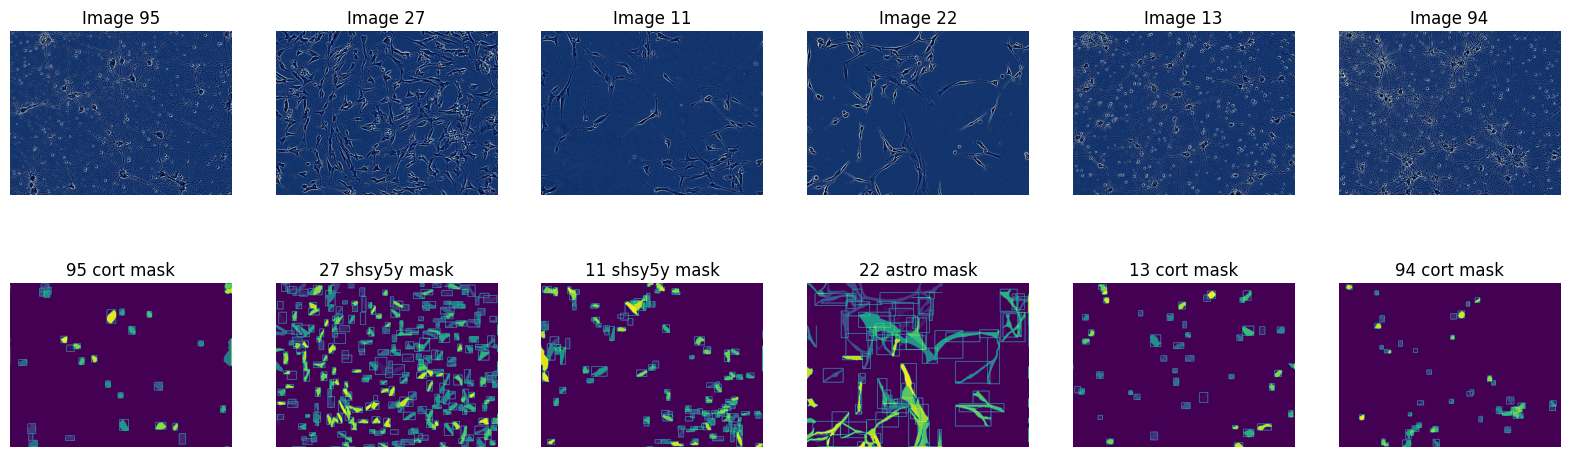

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def display_sampled_images(columns_count):
    '''
    columns_count : number of images to display
    This function displays a 2-row plot with 'columns_count' images on each row from the training dataset.
    The first row shows the images, and the second row shows the corresponding masks and boxes.
    '''
    sample_indexes = random.sample(range(100), columns_count)
    figure, axis = plt.subplots(2, columns_count, figsize=(20, 6))

    for column in range(columns_count):
        image, annotations = dataset_train[sample_indexes[column]]
        all_masks = np.zeros((IMG_HEIGHT, IMG_WIDTH))
        all_boxes = np.zeros((IMG_HEIGHT, IMG_WIDTH))
        axis[0][column].set_title(f"Image {sample_indexes[column]}")
        axis[0][column].imshow(image.numpy().transpose((1, 2, 0)))
        axis[0][column].axis("off")

        for mask in annotations['masks']:
            bounding_box = find_bounding_box(mask)
            all_boxes = np.logical_or(all_boxes, create_boxed_image(bounding_box))

        all_masks = merge_masks(annotations['masks'], 0.5)

        axis[1][column].set_title(f"{sample_indexes[column]} {DICT_TO_CELL[annotations['labels'][0].item()]} mask")
        combined_detections = merge_masks_and_boxes(all_masks, all_boxes)
        axis[1][column].imshow(combined_detections)
        axis[1][column].axis("off")

    plt.show()

# Example of how to call the function
display_sampled_images(6)


## 4. Transformer Baseline

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer

# class TransformerSegmentationModel(nn.Module):
#     def __init__(self, img_size_w, img_size_h, patch_size_w, patch_size_h, num_classes, dim, depth, heads, mlp_dim, decoder_layers):
#         super(TransformerSegmentationModel, self).__init__()
#         # Corrected assertion to check both dimensions
#         assert img_size_w % patch_size_w == 0 and img_size_h % patch_size_h == 0, 'Image dimensions must be divisible by the patch size.'
#         # Correct calculation of the total number of patches
#         num_patches = (img_size_w // patch_size_w) * (img_size_h // patch_size_h)
#         patch_dim = patch_size_w * patch_size_h * 3  # Assuming 3 channels (RGB)

#         self.patch_size_w = patch_size_w
#         self.patch_size_h = patch_size_h
#         # Positional embeddings for encoder and decoder
#         self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, dim))
#         self.patch_to_embedding = nn.Linear(patch_dim, dim)

#         # Transformer Encoder
#         encoder_layer = TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim)
#         self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=depth)

#         # Transformer Decoder
#         decoder_layer = TransformerDecoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim)
#         self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=decoder_layers)

#         # Decoder for upsampling
#         # Example upsampling calculation - assuming input is [2, 512, 65, 88] and target is [520, 704]
#         # Upsampling to the original image dimensions
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             # Adjust kernel size, stride, and padding as needed based on your exact feature map size here
#             nn.ConvTranspose2d(128, NUM_CLASSES, kernel_size=3, stride=2, padding=1, output_padding=1),
#         )



#     def forward(self, x):
#       b, c, h, w = x.shape

#       # Calculate the number of patches along each dimension
#       num_patches_side_h = h // self.patch_size_h
#       num_patches_side_w = w // self.patch_size_w
#       #print(f"patches vertical: {num_patches_side_w}" )
#       #print(f"patches horizontal: {num_patches_side_h}" )
#       #print(f"image input: {x.shape}" )
#       # Using unfold to create patches
#       patches = x.unfold(2, self.patch_size_h, self.patch_size_h).unfold(3, self.patch_size_w, self.patch_size_w)
#       patches = patches.contiguous().view(b, c, -1, self.patch_size_h, self.patch_size_w)
#       patches = patches.permute(0, 2, 1, 3, 4).reshape(b, -1, c * self.patch_size_w * self.patch_size_h)
#       #print(f" Patches: {patches.shape}" )

#       # Embedding patches
#       patches = self.patch_to_embedding(patches)
#       #print(f" Patches Embeddings: {patches.shape}" )
#       patches += self.pos_embedding[:patches.size(1)]
#       #print(f" Patches + Pos Embeddings: {patches.shape}" )





#       encoded_patches = self.transformer_encoder(patches)
#       #print(f" encoder patches: {encoded_patches.shape}" )
#       decoded_patches = self.transformer_decoder(encoded_patches, encoded_patches)
#       #print(f" decoder patches out: {decoded_patches.shape}" )
#       # output of shape [batch_size, num_patches, transformer_dim] --> torch.Size([2, 5720, 512])

#       # Transformer encoder and decoder
#       feature_map_size = int((h * w / self.patch_size_h / self.patch_size_w)**0.5)
#       #print("feature mao:", feature_map_size) # --> 75
#       decoded_patches = decoded_patches.permute(0, 2, 1)  # Rearrange to [batch, dim, num_patches]

#       #print("Shape before reshaping:", decoded_patches.shape)
#       # decoded_patches =  before reshaping: torch.Size([2, 512, 5720])
#       feature_height = 65  # Example height dimension
#       feature_width = 88   # Example width dimension
#       decoded_patches_reshaped = decoded_patches.view(b, 512, feature_height, feature_width)
#       #print("Shape after reshaping:", decoded_patches_reshaped.shape)
#       #decoded_patches = decoded_patches.view(b, -1, feature_map_size, feature_map_size)  # Reshape

#       # Assuming the output of the transformer decoder needs reshaping before upsampling



#       # Upsampling to original size
#       out = self.decoder(decoded_patches_reshaped)

#       return out



# # Example model instantiation
# IMG_SIZE_WIDTH = 704  # Example image size
# IMG_SIZE_HEIGHT = 520  # Example image size
# NUM_CLASSES = 10  # Example number of segmentation classes
# model = TransformerSegmentationModel(
#     img_size_w=IMG_SIZE_WIDTH, img_size_h= IMG_SIZE_HEIGHT, patch_size_w= 8, patch_size_h= 8,  num_classes=NUM_CLASSES, dim=512, depth=6, heads=8, mlp_dim=2048, decoder_layers=6
# )


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
# from torchvision.models import resnet50

# class DynamicInstanceSegmentationModel(nn.Module):
#     def __init__(self, img_size_w, img_size_h, patch_size_w, patch_size_h, num_queries, dim, depth, heads, mlp_dim, decoder_layers):
#         super(DynamicInstanceSegmentationModel, self).__init__()
#         # Define a ResNet backbone
#         self.backbone = resnet50(pretrained=True)
#         del self.backbone.fc  # Remove the classification head
#         self.img_size_w = img_size_w
#         self.img_size_h = img_size_h
#         self.patch_size_w = patch_size_w
#         self.patch_size_h = patch_size_h
#         self.num_queries = num_queries

#         # Calculate the total number of patches and patch dimension
#         num_patches = (img_size_w // patch_size_w) * (img_size_h // patch_size_h)
#         patch_dim = patch_size_w * patch_size_h * 3  # Assuming 3 channels (RGB)

#         # Positional embeddings for patches
#         self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + num_queries, dim))
#         self.patch_to_embedding = nn.Linear(patch_dim, dim)

#         # Transformer Encoder
#         encoder_layer = TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim)
#         self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=depth)

#         # Learnable query embeddings for instance queries
#         self.query_embeddings = nn.Parameter(torch.randn(num_queries, dim))

#         # Transformer Decoder
#         decoder_layer = TransformerDecoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim)
#         self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=decoder_layers)

#         # Prediction heads for instance segmentation: presence score and mask generation
#         self.presence_head = nn.Linear(dim, 1)
#         self.mask_head = nn.Sequential(
#             nn.Linear(dim, 256),  # Project to a smaller dimension
#             nn.ReLU(),
#             nn.Linear(256, img_size_h * img_size_w),  # Project to image size
#             nn.Sigmoid(),
#         )

#     def forward(self, x):
#         features = self.backbone(x)
#         b, _, _, _ = x.shape
#         # Create patches
#         patches = x.unfold(2, self.patch_size_h, self.patch_size_h).unfold(3, self.patch_size_w, self.patch_size_w)
#         patches = patches.contiguous().view(b, -1, self.patch_size_h * self.patch_size_w * 3)

#         # Embed patches
#         patches_embed = self.patch_to_embedding(patches)

#         # Combine patch embeddings with positional embeddings
#         pos_embed = self.pos_embedding[:, :patches_embed.size(1), :]
#         embeddings = patches_embed + pos_embed

#         # Process patch embeddings through the transformer encoder
#         encoded_patches = self.transformer_encoder(embeddings)

#         # Prepare decoder input: combine encoded patches with query embeddings
#         query_embed = self.pos_embedding[:, patches_embed.size(1):, :]
#         queries = self.query_embeddings.unsqueeze(0).repeat(b, 1, 1) + query_embed
#         # Ensure this operation concatenates encoded_patches and queries correctly.
#         encoded_patches_and_queries = torch.cat([encoded_patches, queries], dim=1)



#         print(f"encoder patches before decoder {encoded_patches_and_queries.shape}")
#         print(f"queries before decoder {queries.shape}")
#         # Process through the transformer decoder
#         decoded_output = self.transformer_decoder(queries, encoded_patches_and_queries)

#         # Apply prediction heads
#         presence_scores = self.presence_head(decoded_output).squeeze(-1)
#         raw_masks = self.mask_head(decoded_output)
#         masks = raw_masks.view(b, self.num_queries, self.img_size_h, self.img_size_w)

#         return presence_scores, masks

# # Model instantiation example
# model = DynamicInstanceSegmentationModel(
#     img_size_w=704,
#     img_size_h=520,
#     patch_size_w=8,
#     patch_size_h=8,
#     num_queries=100,  # Assuming a max of 100 instances per image
#     dim=512,
#     depth=6,
#     heads=8,
#     mlp_dim=2048,
#     decoder_layers=6
# )


In [ ]:
# import torch
# import torch.nn as nn
# from torchvision.models import resnet50
# from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer

# class DETRModel(nn.Module):
#     def __init__(self, num_classes, num_queries, hidden_dim, nheads, num_encoder_layers, num_decoder_layers):
#         super(DETRModel, self).__init__()

#         # Backbone
#         self.backbone = resnet50(pretrained=True)
#         del self.backbone.fc

#         # Convolution to reduce the feature space dimension from ResNet's 2048 to hidden_dim
#         self.conv = nn.Conv2d(2048, hidden_dim, kernel_size=1)  # This reduces the channel dimension from 2048 to hidden_dim

#         # Positional encodings for the transformer
#         self.pos_encoding = nn.Parameter(torch.randn(1, 1000, hidden_dim))

#         # Transformer Encoder
#         encoder_layer = TransformerEncoderLayer(d_model=hidden_dim, nhead=nheads, dim_feedforward=hidden_dim)
#         self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

#         # Transformer Decoder
#         decoder_layer = TransformerDecoderLayer(d_model=hidden_dim, nhead=nheads, dim_feedforward=hidden_dim)
#         self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

#         # Object queries
#         self.query_embed = nn.Embedding(num_queries, hidden_dim)

#         # Prediction heads, one for class and one for bounding box
#         self.class_head = nn.Linear(hidden_dim, num_classes + 1)  # +1 for no-object class
#         self.bbox_head = nn.Linear(hidden_dim, 4)  # We predict 4 values for the bounding box

#         # Initialization
#         self.init_weights()

#     def init_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.xavier_uniform_(m.weight)
#                 nn.init.constant_(m.bias, 0)

#     def forward(self, x):
#               # Backbone processing
#         x = self.backbone.conv1(x)
#         x = self.backbone.bn1(x)
#         x = self.backbone.relu(x)
#         x = self.backbone.maxpool(x)

#         x = self.backbone.layer1(x)
#         x = self.backbone.layer2(x)
#         x = self.backbone.layer3(x)
#         x = self.backbone.layer4(x)  # The output here should have 2048 channels

#         # Correctly apply the 1x1 conv to reduce channels from 2048 to hidden_dim
#         x = self.conv(x)  # Only apply it once!

#         # Feature map shape logging
#         print(f"feature map from backbone shape {x.shape}")

#         # Reduce channel dimensions to hidden_dim and flatten for transformer
#         h, w = x.shape[-2:]
#         x = x.flatten(2).permute(0, 2, 1)  # Flatten and permute to get [batch_size, HW, hidden_dim]

#         # Prepare positional encodings
#         pos_encoding = self.pos_encoding[:, :h * w, :].to(x.dtype)
#         if x.is_cuda:
#             pos_encoding = pos_encoding.cuda()
#         pos_encoding = pos_encoding.repeat(x.size(0), 1, 1)

#         # Feature map and positional encodings shape logging
#         print(f"feature map {x.shape}")
#         print(f"pos_encoding shape {pos_encoding.shape}")

#         # Add positional encodings to the input features
#         x = x + pos_encoding

#         # Transformer encoder
#         memory = self.transformer_encoder(x)

#         # Prepare queries for the decoder, adding positional encodings if needed
#         queries = self.query_embed.weight.unsqueeze(1).repeat(1, x.size(1), 1)
#         # If you have separate positional embeddings for queries, you can add them here
#         # queries = queries + query_pos_embedding

#         # Prepare the target tensor for the transformer decoder
#         tgt = torch.zeros_like(queries)  # Initial target is set to zeros

#         # Transformer decoder
#         # Remove the pos argument since it is not expected
#         hs = self.transformer_decoder(tgt, memory)  # Pass only the expected arguments






#         # Class and bounding box prediction
#         outputs_class = self.class_head(hs)
#         outputs_bbox = self.bbox_head(hs).sigmoid()  # Normalize bounding box values

#         out = {'pred_logits': outputs_class[-1], 'pred_boxes': outputs_bbox[-1]}
#         return out

# # Model instantiation
# model = DETRModel(
#     num_classes=91,  # For COCO dataset; change as needed for your dataset
#     num_queries=100,
#     hidden_dim=512,
#     nheads=8,
#     num_encoder_layers=6,
#     num_decoder_layers=6
# )


In [ ]:
# import torch
# import torch.nn as nn
# from torchvision.models import resnet50
# from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
# import torch.nn.functional as F
# class DETRModel(nn.Module):
#     def __init__(self, num_classes, num_queries, hidden_dim, nheads, num_encoder_layers, num_decoder_layers, img_height, img_width):
#         super(DETRModel, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.mask_height = img_height  # Adding mask height
#         self.mask_width = img_width    # Adding mask width

#         # Backbone
#         self.backbone = resnet50(pretrained=True)
#         del self.backbone.fc

#         # Convolution to reduce the feature space dimension from ResNet's 2048 to hidden_dim
#         self.conv = nn.Conv2d(2048, hidden_dim, kernel_size=1)  # This reduces the channel dimension from 2048 to hidden_dim

#         # Positional encodings for the transformer
#         self.pos_encoding = nn.Parameter(torch.randn(1, 1000, hidden_dim))

#         # Transformer Encoder
#         encoder_layer = TransformerEncoderLayer(d_model=hidden_dim, nhead=nheads, dim_feedforward=hidden_dim)
#         self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

#         # Transformer Decoder
#         decoder_layer = TransformerDecoderLayer(d_model=hidden_dim, nhead=nheads, dim_feedforward=hidden_dim)
#         self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

#         # Object queries
#         self.query_embed = nn.Embedding(num_queries, hidden_dim)

#         # Prediction heads, one for class and one for bounding box
#         self.class_head = nn.Linear(hidden_dim, num_classes + 1)  # +1 for no-object class
#         self.bbox_head = nn.Linear(hidden_dim, 4)  # We predict 4 values for the bounding box

#         # Adjusted mask head
#                 # Adjusted mask head
#         self.mask_head = nn.Sequential(
#             nn.Linear(hidden_dim, 128 * 34 * 44),  # First projection to an intermediate size
#             nn.ReLU(),
#             nn.Unflatten(1, (128, 34, 44)),  # Unflatten to spatial dimensions
#             nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             # Final layer to get to the target size, adjust stride and padding as needed
#             nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.Sigmoid(),  # Assuming binary mask output
#         )

#         # Initialization
#         self.init_weights()

#     def init_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.xavier_uniform_(m.weight)
#                 nn.init.constant_(m.bias, 0)

#     def forward(self, x):
#               # Backbone processing
#         x = self.backbone.conv1(x)
#         x = self.backbone.bn1(x)
#         x = self.backbone.relu(x)
#         x = self.backbone.maxpool(x)

#         x = self.backbone.layer1(x)
#         x = self.backbone.layer2(x)
#         x = self.backbone.layer3(x)
#         x = self.backbone.layer4(x)  # The output here should have 2048 channels

#         # Correctly apply the 1x1 conv to reduce channels from 2048 to hidden_dim
#         x = self.conv(x)  # Only apply it once!

#         # Feature map shape logging
#         print(f"feature map from backbone shape {x.shape}")

#         # Reduce channel dimensions to hidden_dim and flatten for transformer
#         h, w = x.shape[-2:]
#         x = x.flatten(2).permute(0, 2, 1)  # Flatten and permute to get [batch_size, HW, hidden_dim]

#         # Prepare positional encodings
#         pos_encoding = self.pos_encoding[:, :h * w, :].to(x.dtype)
#         if x.is_cuda:
#             pos_encoding = pos_encoding.cuda()
#         pos_encoding = pos_encoding.repeat(x.size(0), 1, 1)

#         # Feature map and positional encodings shape logging
#         print(f"feature map {x.shape}")
#         print(f"pos_encoding shape {pos_encoding.shape}")

#         # Add positional encodings to the input features
#         x = x + pos_encoding

#         # Transformer encoder
#         memory = self.transformer_encoder(x)

#         # Prepare queries for the decoder, adding positional encodings if needed
#         queries = self.query_embed.weight.unsqueeze(1).repeat(1, x.size(1), 1)
#         # If you have separate positional embeddings for queries, you can add them here
#         # queries = queries + query_pos_embedding

#         # Prepare the target tensor for the transformer decoder
#         tgt = torch.zeros_like(queries)  # Initial target is set to zeros

#         # Transformer decoder
#         # Remove the pos argument since it is not expected
#         hs = self.transformer_decoder(tgt, memory)  # Pass only the expected arguments

#         # Class and bounding box prediction
#         # Predict class and bounding boxes
#                 # After transformer decoder
#         # Generating masks
#         batch_size, num_queries, _ = hs.shape
#         #Debug
#         print(f"model batch size{batch_size}")
#         print(f"num of queries{num_queries}")
#         print(f"input shape mask head{hs.view(-1, self.hidden_dim).shape}")
#         masks = self.mask_head(hs.view(-1, self.hidden_dim))
#         print(f"masks after mask head{masks.shape}")
#         masks = masks.view(batch_size, num_queries, self.mask_height, self.mask_width)

#         out = {
#             'pred_logits': self.class_head(hs),
#             'pred_boxes': self.bbox_head(hs).sigmoid(),
#             'pred_masks': masks
#         }
#         return out

# img_height = 520
# img_width = 704
# model = DETRModel(num_classes=10, num_queries=1, hidden_dim=256, nheads=4, num_encoder_layers=3, num_decoder_layers=3, img_height=img_height, img_width=img_width)

# # # Model instantiation
# # model = DETRModel(
# #     num_classes=10,  # For COCO dataset; change as needed for your dataset
# #     num_queries=10,
# #     hidden_dim=512,
# #     nheads=8,
# #     num_encoder_layers=6,
# #     num_decoder_layers=6
# # )


In [ ]:
# import torch
# import torch.nn as nn
# from torchvision.models import resnet50
# from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
# import torch.nn.functional as F
# class DETRModel(nn.Module):
#     def __init__(self, num_classes, num_queries, hidden_dim, nheads, num_encoder_layers, num_decoder_layers, img_height, img_width):
#         super(DETRModel, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.mask_height = img_height  # Adding mask height
#         self.mask_width = img_width    # Adding mask width
#         self.nheads = nheads
#         # Backbone
#         self.backbone = resnet50(pretrained=True)
#         del self.backbone.fc

#         # Convolution to reduce the feature space dimension from ResNet's 2048 to hidden_dim
#         self.conv = nn.Conv2d(2048, hidden_dim, kernel_size=1)  # This reduces the channel dimension from 2048 to hidden_dim

#         # Positional encodings for the transformer
#         self.pos_encoding = nn.Parameter(torch.randn(1, 1000, hidden_dim))

#         # Transformer Encoder
#         encoder_layer = TransformerEncoderLayer(d_model=hidden_dim, nhead=nheads, dim_feedforward=hidden_dim)
#         self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

#         # Transformer Decoder
#         decoder_layer = TransformerDecoderLayer(d_model=hidden_dim, nhead=nheads, dim_feedforward=hidden_dim)
#         self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

#         # Object queries
#         self.query_embed = nn.Embedding(num_queries, hidden_dim)

#         # Prediction heads, one for class and one for bounding box
#         self.class_head = nn.Linear(hidden_dim, num_classes + 1)  # +1 for no-object class
#         self.bbox_head = nn.Linear(hidden_dim, 4)  # We predict 4 values for the bounding box

#         # Adjusted mask head
#                 # Adjusted mask head
#         self.mask_head = nn.Sequential(
#             nn.Linear(hidden_dim, 128 * 34 * 44),  # First projection to an intermediate size
#             nn.ReLU(),
#             nn.Unflatten(1, (128, 34, 44)),  # Unflatten to spatial dimensions
#             nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             # Final layer to get to the target size, adjust stride and padding as needed
#             nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.Sigmoid(),  # Assuming binary mask output
#         )

#         # Initialization
#         self.init_weights()

#     def init_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.xavier_uniform_(m.weight)
#                 nn.init.constant_(m.bias, 0)

#     def forward(self, x):
#               # Backbone processing
#         x = self.backbone.conv1(x)
#         x = self.backbone.bn1(x)
#         x = self.backbone.relu(x)
#         x = self.backbone.maxpool(x)

#         x = self.backbone.layer1(x)
#         x = self.backbone.layer2(x)
#         x = self.backbone.layer3(x)
#         x = self.backbone.layer4(x)  # The output here should have 2048 channels

#         # Correctly apply the 1x1 conv to reduce channels from 2048 to hidden_dim
#         x = self.conv(x)  # Only apply it once!

#         # Feature map shape logging
#         print(f"feature map from backbone shape {x.shape}")
#         #feature map from backbone shape torch.Size([1, 256, 17, 22]) (batch_Size, embedding_size, w,h)

#         # Reduce channel dimensions to hidden_dim and flatten for transformer
#         h, w = x.shape[-2:]
#         x = x.flatten(2).permute(0, 2, 1)  # Flatten and permute to get [batch_size, HW, hidden_dim]

#         # Prepare positional encodings
#         pos_encoding = self.pos_encoding[:, :h * w, :].to(x.dtype)
#         if x.is_cuda:
#             pos_encoding = pos_encoding.cuda()
#         pos_encoding = pos_encoding.repeat(x.size(0), 1, 1)

#         # Feature map and positional encodings shape logging
#         print(f"feature map {x.shape}")
#         print(f"pos_encoding shape {pos_encoding.shape}")

#         # Add positional encodings to the input features
#         x = x + pos_encoding

#         # Transformer encoder
#         memory = self.transformer_encoder(x)
#         print(f"memory size {memory.shape}")
#         # Prepare queries for the decoder, adding positional encodings if needed
#         # wrong: queries = self.query_embed.weight.unsqueeze(1).repeat(1, x.size(1), 1)
#         # Ensure queries are correctly shaped as [batch_size, num_queries, hidden_dim]
#         # Correctly shape queries based on dynamic batch size from x
#         batch_size = x.size(0)  # Dynamically get the batch size from input
#         queries = self.query_embed.weight.unsqueeze(0).repeat(batch_size, 1, 1)



#         print(f"queries size {queries.shape}")
#         # If you have separate positional embeddings for queries, you can add them here
#         # queries = queries + query_pos_embedding

#         # Prepare the target tensor for the transformer decoder
#         tgt = torch.zeros_like(queries)  # Initial target is set to zeros
#         print(f"tgt size {tgt.shape}")
#         # Transformer decoder
#         # Remove the pos argument since it is not expected
#         # Before calling the transformer decoder
#         head_size = self.hidden_dim // self.nheads  # This assumes you have `self.nheads` defined in `__init__`
#         inferred_nheads = self.hidden_dim // head_size
#         print(f"Inferred number of heads: {inferred_nheads}")
#         # Just before calling the transformer decoder
#         print(f"Number of heads: {self.transformer_decoder.layers[0].multihead_attn.num_heads}")
#         print(f"Attention head size: {self.transformer_decoder.layers[0].multihead_attn.head_dim}")

#         hs = self.transformer_decoder(tgt, memory)  # Pass only the expected arguments

#         # Class and bounding box prediction
#         # Predict class and bounding boxes
#                 # After transformer decoder
#         # Generating masks
#         batch_size, num_queries, _ = hs.shape
#         #Debug
#         print(f"model batch size{batch_size}")
#         print(f"num of queries{num_queries}")
#         print(f"input shape mask head{hs.view(-1, self.hidden_dim).shape}")
#         masks = self.mask_head(hs.view(-1, self.hidden_dim))
#         print(f"masks after mask head{masks.shape}")
#         masks = masks.view(batch_size, num_queries, self.mask_height, self.mask_width)

#         out = {
#             'pred_logits': self.class_head(hs),
#             'pred_boxes': self.bbox_head(hs).sigmoid(),
#             'pred_masks': masks
#         }
#         return out

# img_height = 520
# img_width = 704
# model = DETRModel(num_classes=10, num_queries=3, hidden_dim=512, nheads=16, num_encoder_layers=6, num_decoder_layers=6, img_height=img_height, img_width=img_width)

# # # Model instantiation
# # model = DETRModel(
# #     num_classes=10,  # For COCO dataset; change as needed for your dataset
# #     num_queries=10,
# #     hidden_dim=512,
# #     nheads=8,
# #     num_encoder_layers=6,
# #     num_decoder_layers=6
# # )


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
import torch.nn.functional as F
class DETRModel(nn.Module):
    def __init__(self, num_classes, num_queries, hidden_dim, nheads, num_encoder_layers, num_decoder_layers, img_height, img_width):
        super(DETRModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.mask_height = img_height  # Adding mask height
        self.mask_width = img_width    # Adding mask width
        self.nheads = nheads
        # Backbone
        self.backbone = resnet50(pretrained=True)
        del self.backbone.fc

        # Convolution to reduce the feature space dimension from ResNet's 2048 to hidden_dim
        self.conv = nn.Conv2d(2048, hidden_dim, kernel_size=1)  # This reduces the channel dimension from 2048 to hidden_dim

        # Positional encodings for the transformer
        self.pos_encoding = nn.Parameter(torch.randn(1, 1000, hidden_dim))

        # Transformer Encoder
        encoder_layer = TransformerEncoderLayer(d_model=hidden_dim, nhead=nheads, dim_feedforward=hidden_dim)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # Transformer Decoder
        decoder_layer = TransformerDecoderLayer(d_model=hidden_dim, nhead=nheads, dim_feedforward=hidden_dim)
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        # Object queries
        self.query_embed = nn.Embedding(num_queries, hidden_dim)

        # Prediction heads, one for class and one for bounding box
        self.class_head = nn.Linear(hidden_dim, num_classes + 1)  # +1 for no-object class
        self.bbox_head = nn.Linear(hidden_dim, 4)  # We predict 4 values for the bounding box

        # Adjusted mask head
                # Adjusted mask head
        self.mask_head = nn.Sequential(
            nn.Linear(hidden_dim, 128 * 34 * 44),  # First projection to an intermediate size
            nn.ReLU(),
            nn.Unflatten(1, (128, 34, 44)),  # Unflatten to spatial dimensions
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            # Final layer to get to the target size, adjust stride and padding as needed
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),  # Assuming binary mask output
        )

        # Initialization
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
              # Backbone processing
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)


        x = self.conv(x)  # Only apply it once!

        print(f"feature map {x.shape}")
        print(f"feature map from backbone shape {x.shape}")

        h, w = x.shape[-2:]

        seq_len = x.shape[2] * x.shape[3]  # h * w
        x_flattened = x.flatten(2).permute(2, 0, 1)  # [seq_len, batch_size, channels]



        # Adjust the positional encoding to match the sequence length
        if seq_len > self.pos_encoding.size(1):
            # Optionally, handle cases where seq_len exceeds the size of predefined pos_encoding
            raise ValueError("Sequence length exceeds the pre-defined positional encoding length.")
        pos_encoding_adjusted = self.pos_encoding[:, :seq_len, :]

        # Ensure it's repeated correctly for the batch size
        pos_encoding_adjusted = pos_encoding_adjusted.repeat(x.size(0), 1, 1)

        print(f"x_flattened shape {x_flattened.shape}")
        print(f"pos_encoding_adjusted shape {pos_encoding_adjusted.shape}")
        memory_input = x_flattened + pos_encoding_adjusted

        print(f"memory_input shape {memory_input.shape}")


        # Encoder
        memory = self.transformer_encoder(memory_input)
        print(f"memory size {memory.shape}")
        # Prepare queries for the decoder
        queries = self.query_embed.weight.unsqueeze(0).repeat(x.size(0), 1, 1)
        tgt = torch.zeros_like(queries)
        print(f"queries size {queries.shape}")
        print(f"tgt size {tgt.shape}")
        # Decoder
        #hs = self.transformer_decoder(tgt, memory + pos_encoding_adjusted)  # Ensure positional encoding is added to memory if necessary
        # Correct decoder call
        hs = self.transformer_decoder(tgt, memory)




        batch_size, num_queries, _ = hs.shape
        #Debug
        print(f"model batch size{batch_size}")
        print(f"num of queries{num_queries}")
        print(f"input shape mask head{hs.view(-1, self.hidden_dim).shape}")
        masks = self.mask_head(hs.view(-1, self.hidden_dim))
        print(f"masks after mask head{masks.shape}")
        masks = masks.view(batch_size, num_queries, self.mask_height, self.mask_width)

        out = {
            'pred_logits': self.class_head(hs),
            'pred_boxes': self.bbox_head(hs).sigmoid(),
            'pred_masks': masks
        }
        return out

img_height = 520
img_width = 704
model = DETRModel(num_classes=10, num_queries=3, hidden_dim=512, nheads=16, num_encoder_layers=6, num_decoder_layers=6, img_height=img_height, img_width=img_width)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast

In [ ]:
first_batch = next(iter(dl_train))
images, targets = first_batch
print("Batch images type:", type(images))
print("Batch images shape:", images.shape if isinstance(images, torch.Tensor) else "N/A")
print("Batch targets type:", type(targets))
print("Batch targets type:", type(targets['masks'][0]))
print("Lenth targets list:", len(targets['masks']))
#print("mask targets type elemt 2:", targets['masks'][1].shape)



Batch images type: <class 'torch.Tensor'>
Batch images shape: torch.Size([1, 3, 520, 704])
Batch targets type: <class 'dict'>
Batch targets type: <class 'torch.Tensor'>
Lenth targets list: 1


In [ ]:
# Install tqdm:
try:
    import tqdm
except ImportError:
    !pip install tqdm

In [ ]:
import torch.optim as optim
STEP_SIZE = 3
GAMMA = 0.1
from tqdm import tqdm
# Model, optimizer, and loss function setup
model.to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
loss_function = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0

    for batch in tqdm(dl_train, desc="Train BATCHES"):
      # Your existing training code...
      images, targets = batch  # Unpack the batch

      # Since images is a tuple of tensors, process each tensor to move it to DEVICE
      images = images.to(DEVICE)


      masks = [mask.to(DEVICE) for mask in targets['masks']]
      optimizer.zero_grad()

      output = model(images)
      #print(f"output shape: {output.shape}" )
      #print(f"mask shape: {masks}" )å
      # Example to convert list of masks to a single tensor for CrossEntropyLoss
      #This is conceptual and might need adjustments based on your exact task
      masks_tensor = torch.stack([torch.max(masks[i], dim=0)[0] for i in range(len(masks))])
      loss = loss_function(output, masks_tensor.long())
      #loss = loss_function(output, masks.long())  # Ensure masks are in the correct dtype for CrossEntropyLoss
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    lr_scheduler.step()
    tqdm.write(f"Epoch {epoch+1}, Loss: {total_loss / len(dl_train)}")

    # Evaluation for mean Average Precision (mAP) after each epoch
    model.eval()  # Set the model to evaluation mode

    # Initialize lists to store ground truth and predicted masks for the entire validation dataset
    ground_truth_masks_all = []
    predicted_masks_all = []

    with torch.no_grad():  # Disable gradient calculation for inference
        for batch in tqdm(dl_val, desc="Evaluating mAP"):
            images, targets = batch  # Unpack the batch
            images = images.to(DEVICE)
            predictions = model(images)  # Perform prediction
            # Convert predictions to masks and store them
            predicted_masks = ...  # Your method to convert predictions to masks
            predicted_masks_all.append(predicted_masks)

            # Store the ground truth masks
            ground_truth_masks = ...  # Your method to retrieve ground truth masks from targets
            ground_truth_masks_all.append(ground_truth_masks)

    # Calculate the mAP for the current epoch
    mean_ap = calculate_mean_average_precision(ground_truth_masks_all, predicted_masks_all, verbose=0)
    tqdm.write(f"Epoch {epoch+1}, mAP: {mean_ap}")

    # Switch back to training mode
    model.train()


Train BATCHES:   0%|          | 0/606 [00:00<?, ?it/s]

feature map torch.Size([1, 512, 17, 22])
feature map from backbone shape torch.Size([1, 512, 17, 22])
x_flattened shape torch.Size([374, 1, 512])
pos_encoding_adjusted shape torch.Size([1, 374, 512])
memory_input shape torch.Size([374, 374, 512])


Train BATCHES:   0%|          | 0/606 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 820.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 81.06 MiB is free. Process 367640 has 14.67 GiB memory in use. Of the allocated memory 14.34 GiB is allocated by PyTorch, and 198.87 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import torch.optim as optim
STEP_SIZE = 3
GAMMA = 0.1
from tqdm import tqdm


# Model, optimizer, and loss function setup
model.to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
loss_function = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(NUM_EPOCHS) :
    model.train()
    total_loss = 0

    # Adding tqdm progress bar for batches
    #batch_iterator = tqdm(dl_train, desc="Batches", leave=False)

    for batch in tqdm(dl_train, desc="Train BATCHES"):
      images, targets = batch  # Unpack the batch

      # Since images is a tuple of tensors, process each tensor to move it to DEVICE
      images = images.to(DEVICE)

      # Assuming targets['masks'] is also a tuple of tensors if following similar pattern
      # You'll need to adjust this part based on the actual structure of targets
      #print("Type of targets:", type(targets))
      #print("First element of targets:", targets[0] if len(targets) > 0 else "Empty")

      #masks = tuple(target['masks'].to(DEVICE) for target in targets)
      masks = [mask.to(DEVICE) for mask in targets['masks']]
      optimizer.zero_grad()
      #print(type(images), images.shape if isinstance(images, torch.Tensor) else "Not a tensor")

      output = model(images)
      #print(f"output shape: {output.shape}" )
      #print(f"mask shape: {masks}" )å
      # Example to convert list of masks to a single tensor for CrossEntropyLoss
      #This is conceptual and might need adjustments based on your exact task
      masks_tensor = torch.stack([torch.max(masks[i], dim=0)[0] for i in range(len(masks))])
      loss = loss_function(output, masks_tensor.long())
      #loss = loss_function(output, masks.long())  # Ensure masks are in the correct dtype for CrossEntropyLoss
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    lr_scheduler.step()
    tqdm.write(f"Epoch {epoch+1}, Loss: {total_loss / len(dl_train)}")

In [ ]:
import torch
import numpy as np
from torchvision.models.segmentation import deeplabv3_resnet50
from timm.models import create_model
from torch import nn

# Example of instantiating a Swin Transformer model
# This assumes you have a segmentation head ready or are using a framework that provides one
model = create_model('swin_small_patch4_window7_224', pretrained=True, num_classes=NUM_CLASSES)  # NUM_CLASSES is your dataset's number of classes

# Add a custom segmentation head if necessary (this is highly dependent on your setup and framework)
model.head = CustomSegmentationHead(...)  # Define or configure your segmentation head here


In [ ]:
from torch.utils.data import DataLoader

# Assuming 'CellDataset' is your dataset class
dataset_train = CellDataset(image_dir=TRAIN_DIR, df=train_df, transforms=get_transform(train=True))
dl_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

# Optimizer and scheduler setup remains the same
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

for epoch in range(NUM_EPOCHS):
    model.train()
    for images, targets in dl_train:
        images = list(img.to(DEVICE) for img in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward and optimize
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    # Update the learning rate
    lr_scheduler.step()
